ADVANCED MARKETPLACE ANALYSIS

1. DATA PREPARATION
----------------------------------------
✓ Loaded data: 625 venues, 26532 searches, 9110 bookings
✓ Created venue performance dataset
✓ Created search conversion dataset

2. LIQUIDITY SCORE PREDICTION MODEL
----------------------------------------
✓ Created liquidity dataset with 54 monthly observations

📊 Liquidity Score Prediction Results:
   MAE: 4.60
   RMSE: 5.94
   R²: 0.451


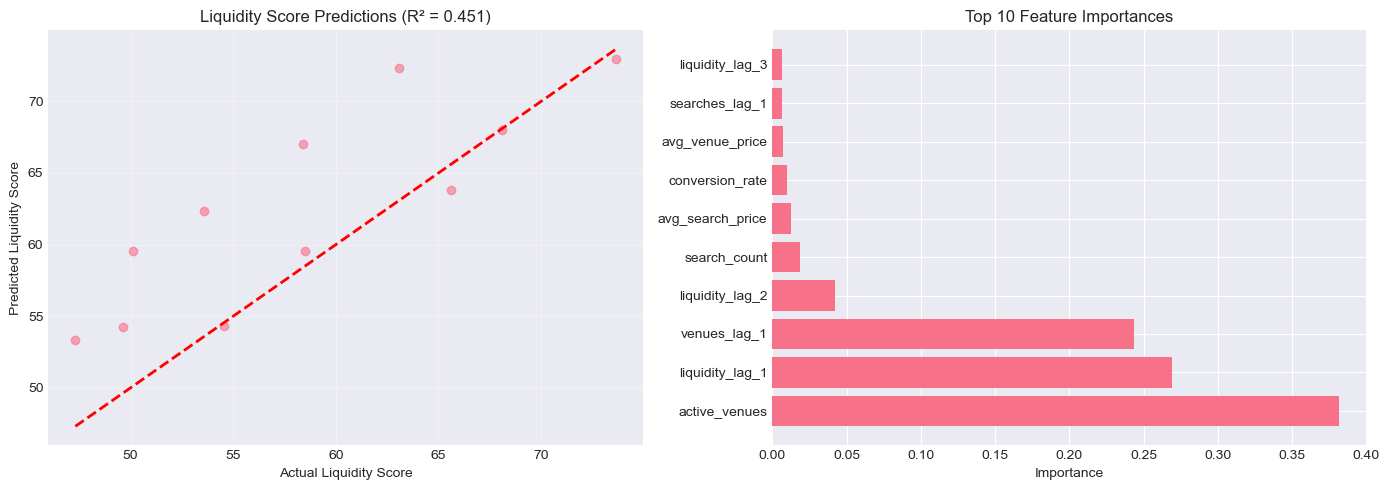


✓ Top 3 predictive features:
   active_venues: 0.381
   liquidity_lag_1: 0.269
   venues_lag_1: 0.243

3. PRICE ELASTICITY MODELING
----------------------------------------
✓ Price Elasticity by Venue Type:
   photo_studio: -0.05 (Inelastic)
   event_space: 0.08 (Inelastic)
   meeting_room: 0.04 (Inelastic)
   workshop_space: 0.11 (Inelastic)
   rooftop: -0.07 (Inelastic)


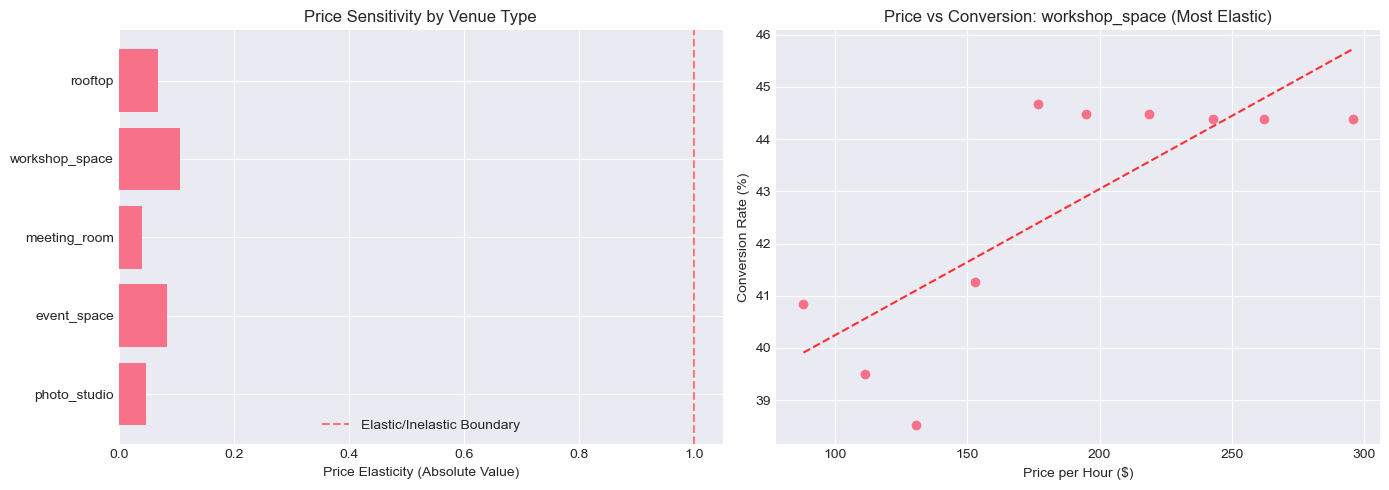


4. MARKET SEGMENTATION ANALYSIS
----------------------------------------
✓ Market Segments Identified:

   Segment 1: Growth Opportunity Markets
   Metros: New York
   Strategy: Supply acquisition, market education
   Avg Conversion: 36.8%
   Supply/Demand: 0.016

   Segment 2: Growth Opportunity Markets
   Metros: Chicago, Austin, Miami
   Strategy: Supply acquisition, market education
   Avg Conversion: 31.2%
   Supply/Demand: 0.016

   Segment 3: Growth Opportunity Markets
   Metros: San Francisco, Los Angeles
   Strategy: Supply acquisition, market education
   Avg Conversion: 38.1%
   Supply/Demand: 0.040


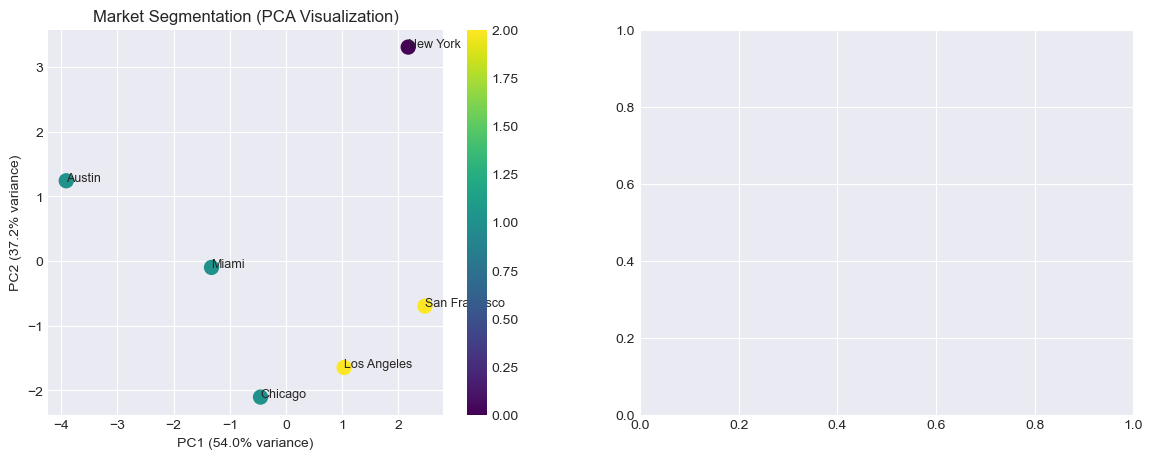

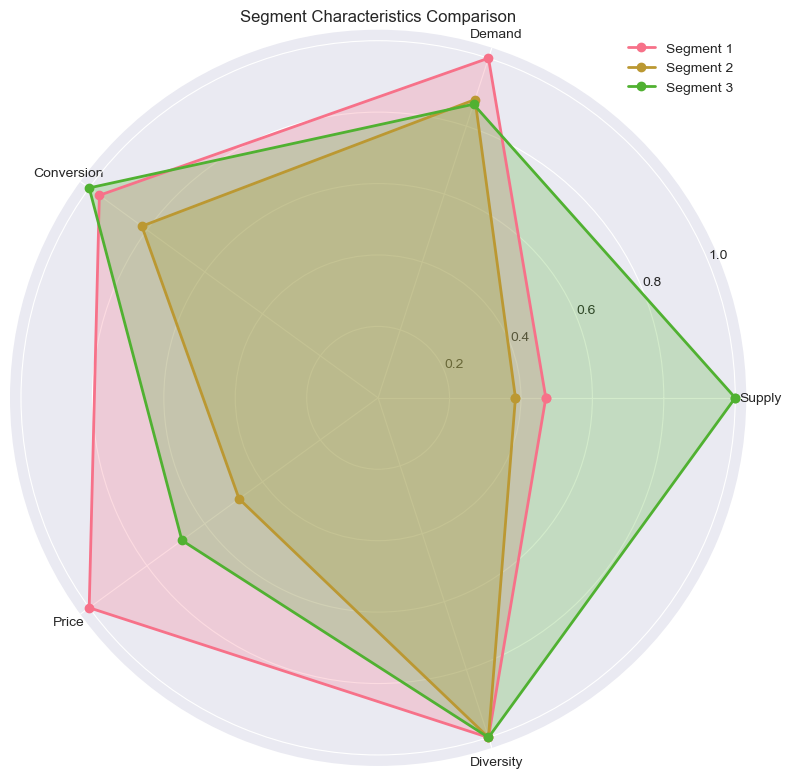


5. DEMAND FORECASTING MODEL
----------------------------------------
✓ Demand Forecast Accuracy:
   MAE: 22.51 searches/day
   RMSE: 28.64 searches/day


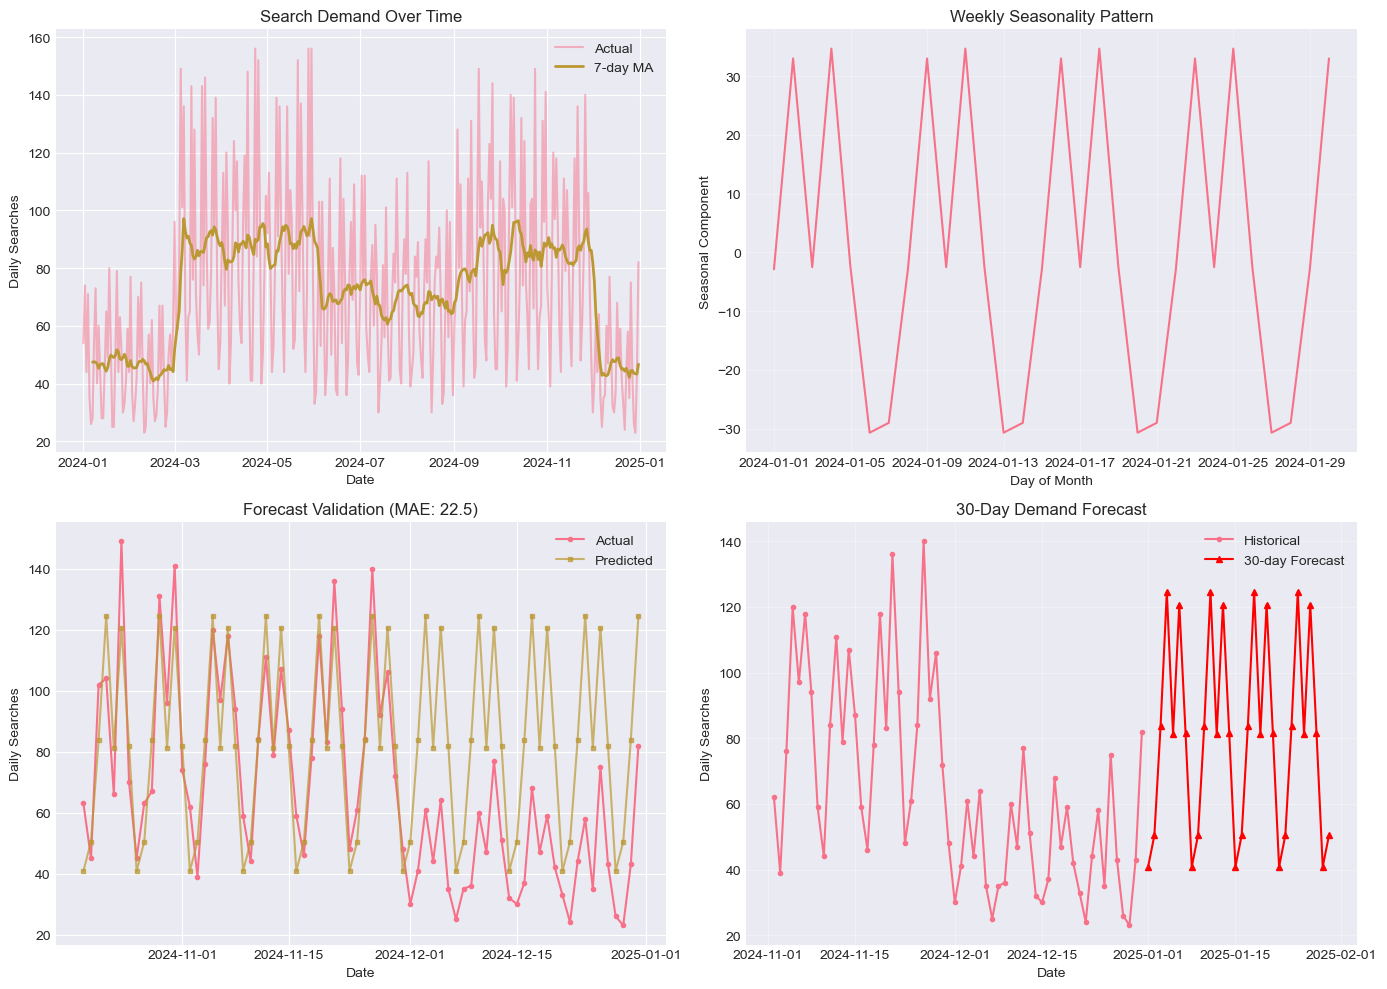


✓ Next 30 days forecast:
   Expected total searches: 2425
   Daily average: 80.8
   Peak day: 2025-01-04

6. SEARCH CONVERSION PREDICTION
----------------------------------------
✓ Conversion Prediction Model Performance:
   Accuracy: 0.653
   Precision: 0.487
   Recall: 0.326
   F1 Score: 0.391

✓ Top factors affecting conversion:
   avg_matching_price: 0.336
   matching_venues: 0.287
   max_price: 0.106
   metro_encoded: 0.059
   capacity_needed: 0.048

ADVANCED ANALYSIS SUMMARY

🎯 KEY INSIGHTS:
----------------------------------------

1. PREDICTIVE CAPABILITIES:
   • Liquidity score prediction R²: 0.451
   • Demand forecast accuracy (MAE): 22.5 searches/day
   • Conversion prediction accuracy: 65.3%

2. MARKET SEGMENTS:
   • Segment 1: New York
   • Segment 2: Chicago, Austin, Miami
   • Segment 3: San Francisco, Los Angeles

3. PRICE ELASTICITY FINDINGS:

4. DEMAND PATTERNS:
   • Weekly seasonality detected with 34.7 peak variation
   • Next 30 days expected demand: 2425 searches

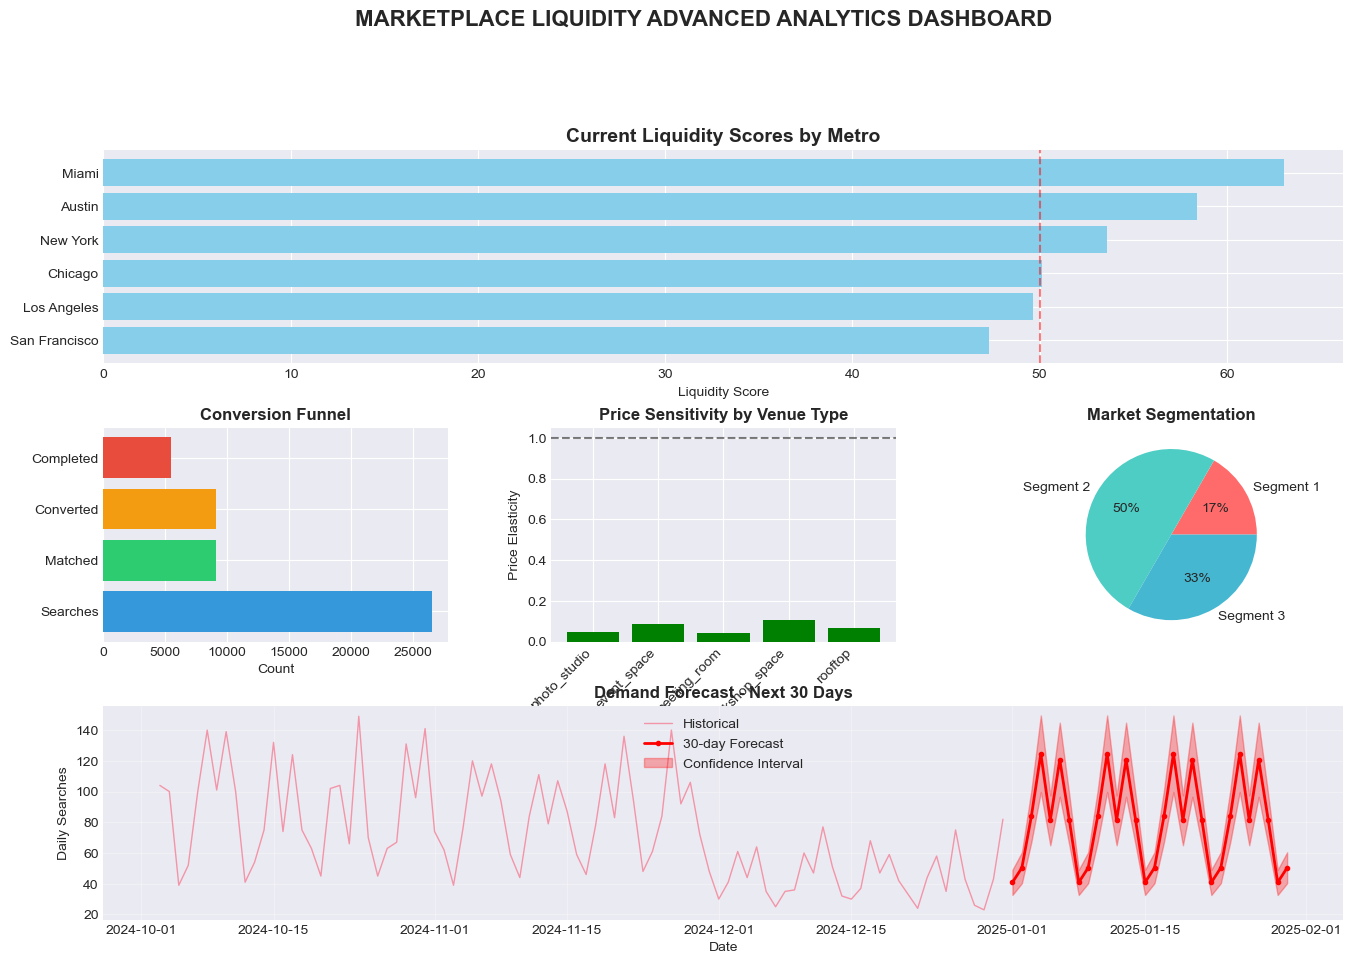


✅ Summary dashboard saved as 'advanced_analysis_summary.png'

✅ Trained models saved for deployment

ADVANCED ANALYSIS COMPLETE!

Next Steps:
1. Review the generated visualizations and insights
2. Import CSV files into Tableau for interactive dashboard
3. Use the recommendations.csv for executive presentation
4. Deploy models using the saved .pkl files


In [7]:
# Advanced Analysis: Predictive Modeling & Market Segmentation
# This notebook builds on SQL analysis to create predictive models and actionable segments

import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Statistical Analysis
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*60)
print("ADVANCED MARKETPLACE ANALYSIS")
print("="*60)

# =====================================================
# SECTION 1: DATA PREPARATION
# =====================================================

print("\n1. DATA PREPARATION")
print("-"*40)

# Connect to database
conn = sqlite3.connect('../data/peerspace_marketplace.db')

# Load all tables with proper date parsing
listings_df = pd.read_sql("SELECT * FROM listings", conn)
searches_df = pd.read_sql("SELECT * FROM searches", conn)
bookings_df = pd.read_sql("SELECT * FROM bookings", conn)
users_df = pd.read_sql("SELECT * FROM users", conn)

# Convert date columns
date_columns = {
    'listings_df': ['created_date'],
    'searches_df': ['search_date', 'event_date'],
    'bookings_df': ['booking_date', 'event_date'],
    'users_df': ['signup_date']
}

for df_name, cols in date_columns.items():
    df = locals()[df_name]
    for col in cols:
        df[col] = pd.to_datetime(df[col])

print(f"✓ Loaded data: {len(listings_df)} venues, {len(searches_df)} searches, {len(bookings_df)} bookings")

# Create enriched datasets for modeling
# 1. Venue Performance Dataset
# First create the aggregation with flattened column names
venue_bookings_agg = bookings_df.groupby('venue_id').agg({
    'booking_id': 'count',
    'total_amount': ['sum', 'mean'],
    'hours_booked': ['sum', 'mean']
})

# Flatten the multi-level column names
venue_bookings_agg.columns = ['_'.join(col).strip() if col[1] else col[0] 
                               for col in venue_bookings_agg.columns.values]
venue_bookings_agg = venue_bookings_agg.reset_index()

# Rename columns for clarity
venue_bookings_agg.columns = ['venue_id', 'total_bookings', 'revenue_total', 
                               'revenue_avg', 'hours_total', 'hours_avg']

# Now merge with listings
venue_performance = listings_df.merge(
    venue_bookings_agg,
    how='left',
    on='venue_id'
)

# Fill NaN values with 0 (venues with no bookings)
venue_performance[['total_bookings', 'revenue_total', 'revenue_avg', 
                   'hours_total', 'hours_avg']] = venue_performance[
    ['total_bookings', 'revenue_total', 'revenue_avg', 'hours_total', 'hours_avg']
].fillna(0)

# Calculate venue age and utilization
venue_performance['venue_age_days'] = (pd.Timestamp('2024-12-31') - venue_performance['created_date']).dt.days
venue_performance['utilization_rate'] = (venue_performance['hours_total'] / (venue_performance['venue_age_days'] * 10)) * 100
venue_performance['utilization_rate'] = venue_performance['utilization_rate'].clip(upper=100)

print("✓ Created venue performance dataset")

# 2. Search Conversion Dataset
search_conversion = searches_df.merge(
    bookings_df[['search_id', 'booking_id', 'status']],
    how='left',
    on='search_id'
)
search_conversion['converted'] = (~search_conversion['booking_id'].isna()).astype(int)
search_conversion['lead_time_days'] = (search_conversion['event_date'] - search_conversion['search_date']).dt.days
search_conversion['search_month'] = search_conversion['search_date'].dt.month
search_conversion['search_weekday'] = search_conversion['search_date'].dt.dayofweek
search_conversion['event_weekday'] = search_conversion['event_date'].dt.dayofweek

print("✓ Created search conversion dataset")

# =====================================================
# SECTION 2: LIQUIDITY HEALTH SCORE PREDICTION
# =====================================================

print("\n2. LIQUIDITY SCORE PREDICTION MODEL")
print("-"*40)

# Aggregate monthly liquidity metrics by metro
monthly_liquidity = []

for month in pd.date_range('2024-01-01', '2024-12-01', freq='MS'):
    month_end = month + pd.DateOffset(months=1) - pd.DateOffset(days=1)
    
    for metro in listings_df['metro_area'].unique():
        # Supply metrics
        active_venues = listings_df[
            (listings_df['metro_area'] == metro) & 
            (listings_df['created_date'] <= month_end) &
            (listings_df['is_active'] == True)
        ].shape[0]
        
        # Demand metrics
        month_searches = searches_df[
            (searches_df['metro_area'] == metro) &
            (searches_df['search_date'] >= month) &
            (searches_df['search_date'] <= month_end)
        ]
        
        search_count = month_searches.shape[0]
        conversion_rate = month_searches['search_resulted_in_booking'].mean() * 100 if search_count > 0 else 0
        
        # Price metrics
        avg_search_price = month_searches['max_price'].mean() if search_count > 0 else 0
        avg_venue_price = listings_df[listings_df['metro_area'] == metro]['price_per_hour'].mean()
        
        # Calculate liquidity score (simplified version)
        if active_venues > 0 and search_count > 0:
            liquidity_score = (
                conversion_rate * 0.4 +
                min((search_count / active_venues) * 10, 100) * 0.3 +
                min((active_venues / 20), 1) * 100 * 0.3
            )
        else:
            liquidity_score = 0
            
        monthly_liquidity.append({
            'month': month,
            'metro_area': metro,
            'active_venues': active_venues,
            'search_count': search_count,
            'conversion_rate': conversion_rate,
            'avg_search_price': avg_search_price,
            'avg_venue_price': avg_venue_price,
            'liquidity_score': liquidity_score
        })

liquidity_df = pd.DataFrame(monthly_liquidity)

# Create lagged features for time series prediction
for lag in [1, 2, 3]:
    liquidity_df[f'liquidity_lag_{lag}'] = liquidity_df.groupby('metro_area')['liquidity_score'].shift(lag)
    liquidity_df[f'searches_lag_{lag}'] = liquidity_df.groupby('metro_area')['search_count'].shift(lag)
    liquidity_df[f'venues_lag_{lag}'] = liquidity_df.groupby('metro_area')['active_venues'].shift(lag)

# Add trend features
liquidity_df['month_num'] = (liquidity_df['month'].dt.year - 2024) * 12 + liquidity_df['month'].dt.month
liquidity_df['is_summer'] = liquidity_df['month'].dt.month.isin([6, 7, 8]).astype(int)
liquidity_df['is_holiday_season'] = liquidity_df['month'].dt.month.isin([11, 12]).astype(int)

# Clean dataset (remove NaN from lagged features)
liquidity_model_df = liquidity_df.dropna()

print(f"✓ Created liquidity dataset with {len(liquidity_model_df)} monthly observations")

# Build prediction model
feature_cols = ['active_venues', 'search_count', 'conversion_rate', 'avg_search_price', 
                'avg_venue_price', 'liquidity_lag_1', 'liquidity_lag_2', 'liquidity_lag_3',
                'searches_lag_1', 'venues_lag_1', 'month_num', 'is_summer', 'is_holiday_season']

X = liquidity_model_df[feature_cols]
y = liquidity_model_df['liquidity_score']

# Time series split (don't shuffle for time series!)
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Liquidity Score Prediction Results:")
print(f"   MAE: {mae:.2f}")
print(f"   RMSE: {rmse:.2f}")
print(f"   R²: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize predictions vs actual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
ax1.scatter(y_test, y_pred, alpha=0.6)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Liquidity Score')
ax1.set_ylabel('Predicted Liquidity Score')
ax1.set_title(f'Liquidity Score Predictions (R² = {r2:.3f})')
ax1.grid(True, alpha=0.3)

# Feature Importance
ax2.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
ax2.set_xlabel('Importance')
ax2.set_title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

print("\n✓ Top 3 predictive features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")

# =====================================================
# SECTION 3: PRICE ELASTICITY ANALYSIS
# =====================================================

print("\n3. PRICE ELASTICITY MODELING")
print("-"*40)

# Prepare price elasticity dataset
price_data = searches_df.merge(
    listings_df[['metro_area', 'venue_type', 'price_per_hour', 'capacity']],
    on=['metro_area', 'venue_type'],
    how='left'
)

# Calculate if search converted based on price
price_data['price_match'] = (price_data['price_per_hour'] <= price_data['max_price']).astype(int)
price_data['capacity_match'] = (price_data['capacity'] >= price_data['capacity_needed'] * 0.8).astype(int)

# Group by venue type and price bands
elasticity_results = []

for venue_type in price_data['venue_type'].unique():
    type_data = price_data[price_data['venue_type'] == venue_type].copy()
    
    if len(type_data) < 50:  # Skip if too few observations
        continue
    
    # Create price bands (quartiles)
    type_data['price_band'] = pd.qcut(type_data['price_per_hour'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Calculate conversion by price band
    band_conversion = type_data.groupby('price_band').agg({
        'search_resulted_in_booking': 'mean',
        'price_per_hour': 'mean',
        'search_id': 'count'
    }).reset_index()
    
    # Calculate elasticity (% change in demand / % change in price)
    if len(band_conversion) > 1:
        prices = band_conversion['price_per_hour'].values
        conversions = band_conversion['search_resulted_in_booking'].values
        
        # Simple elasticity calculation
        price_pct_change = (prices[-1] - prices[0]) / prices[0]
        demand_pct_change = (conversions[-1] - conversions[0]) / conversions[0] if conversions[0] > 0 else 0
        elasticity = demand_pct_change / price_pct_change if price_pct_change != 0 else 0
        
        elasticity_results.append({
            'venue_type': venue_type,
            'elasticity': elasticity,
            'avg_price': prices.mean(),
            'price_range': prices[-1] - prices[0],
            'sample_size': type_data.shape[0]
        })

elasticity_df = pd.DataFrame(elasticity_results)

print("✓ Price Elasticity by Venue Type:")
for idx, row in elasticity_df.iterrows():
    elasticity_type = "Elastic" if abs(row['elasticity']) > 1 else "Inelastic"
    print(f"   {row['venue_type']}: {row['elasticity']:.2f} ({elasticity_type})")

# Visualize price elasticity
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Elasticity by venue type
ax1.barh(elasticity_df['venue_type'], elasticity_df['elasticity'].abs())
ax1.set_xlabel('Price Elasticity (Absolute Value)')
ax1.set_title('Price Sensitivity by Venue Type')
ax1.axvline(x=1, color='r', linestyle='--', alpha=0.5, label='Elastic/Inelastic Boundary')
ax1.legend()

# Price vs Conversion for most elastic type
most_elastic = elasticity_df.loc[elasticity_df['elasticity'].abs().idxmax(), 'venue_type']
elastic_data = price_data[price_data['venue_type'] == most_elastic].copy()

# Bin prices and calculate conversion
elastic_data['price_bin'] = pd.cut(elastic_data['price_per_hour'], bins=10)
price_conversion = elastic_data.groupby('price_bin').agg({
    'search_resulted_in_booking': 'mean',
    'price_per_hour': 'mean'
}).reset_index()

ax2.scatter(price_conversion['price_per_hour'], 
           price_conversion['search_resulted_in_booking'] * 100)
ax2.set_xlabel('Price per Hour ($)')
ax2.set_ylabel('Conversion Rate (%)')
ax2.set_title(f'Price vs Conversion: {most_elastic} (Most Elastic)')

# Fit trend line
z = np.polyfit(price_conversion['price_per_hour'].dropna(), 
               price_conversion['search_resulted_in_booking'].dropna() * 100, 1)
p = np.poly1d(z)
ax2.plot(price_conversion['price_per_hour'], 
         p(price_conversion['price_per_hour']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# =====================================================
# SECTION 4: MARKET SEGMENTATION
# =====================================================

print("\n4. MARKET SEGMENTATION ANALYSIS")
print("-"*40)

# Create metro-level features for clustering
metro_features = pd.DataFrame()

for metro in listings_df['metro_area'].unique():
    metro_listings = listings_df[listings_df['metro_area'] == metro]
    metro_searches = searches_df[searches_df['metro_area'] == metro]
    metro_bookings = bookings_df[bookings_df['venue_id'].isin(metro_listings['venue_id'])]
    
    metro_features = pd.concat([metro_features, pd.DataFrame({
        'metro_area': [metro],
        'supply_count': [len(metro_listings)],
        'demand_count': [len(metro_searches)],
        'booking_count': [len(metro_bookings)],
        'avg_price': [metro_listings['price_per_hour'].mean()],
        'price_std': [metro_listings['price_per_hour'].std()],
        'conversion_rate': [metro_searches['search_resulted_in_booking'].mean()],
        'avg_lead_time': [(metro_searches['event_date'] - metro_searches['search_date']).dt.days.mean()],
        'venue_diversity': [metro_listings['venue_type'].nunique()],
        'supply_demand_ratio': [len(metro_listings) / len(metro_searches) if len(metro_searches) > 0 else 0],
        'avg_booking_value': [metro_bookings['total_amount'].mean() if len(metro_bookings) > 0 else 0]
    })])

metro_features.reset_index(drop=True, inplace=True)

# Standardize features for clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(metro_features.drop('metro_area', axis=1))

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
metro_features['cluster'] = kmeans.fit_predict(features_scaled)

# PCA for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Interpret clusters - only use numeric columns for mean calculation
numeric_cols = metro_features.select_dtypes(include=[np.number]).columns
cluster_profiles = metro_features.groupby('cluster')[numeric_cols.drop('cluster')].mean()

print("✓ Market Segments Identified:")
for cluster_id in range(3):
    cluster_metros = metro_features[metro_features['cluster'] == cluster_id]['metro_area'].values
    profile = cluster_profiles.loc[cluster_id]
    
    # Determine cluster characteristics
    if profile['conversion_rate'] > 0.4 and profile['supply_demand_ratio'] < 0.15:
        segment_name = "High-Performance Markets"
        strategy = "Maintain balance, optimize pricing"
    elif profile['supply_count'] > 100 and profile['conversion_rate'] < 0.35:
        segment_name = "Oversupplied Markets"
        strategy = "Demand generation, host retention"
    else:
        segment_name = "Growth Opportunity Markets"
        strategy = "Supply acquisition, market education"
    
    print(f"\n   Segment {cluster_id + 1}: {segment_name}")
    print(f"   Metros: {', '.join(cluster_metros)}")
    print(f"   Strategy: {strategy}")
    print(f"   Avg Conversion: {profile['conversion_rate']:.1%}")
    print(f"   Supply/Demand: {profile['supply_demand_ratio']:.3f}")

# Visualize clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# PCA visualization
scatter = ax1.scatter(features_pca[:, 0], features_pca[:, 1], 
                     c=metro_features['cluster'], cmap='viridis', s=100)
for i, metro in enumerate(metro_features['metro_area']):
    ax1.annotate(metro, (features_pca[i, 0], features_pca[i, 1]), fontsize=9)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('Market Segmentation (PCA Visualization)')
plt.colorbar(scatter, ax=ax1)

# Cluster characteristics radar chart
categories = ['Supply', 'Demand', 'Conversion', 'Price', 'Diversity']
fig2, ax2 = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

for cluster_id in range(3):
    # Make sure we're only accessing numeric columns that exist
    values = [
        cluster_profiles.loc[cluster_id, 'supply_count'] / cluster_profiles['supply_count'].max() if 'supply_count' in cluster_profiles.columns else 0,
        cluster_profiles.loc[cluster_id, 'demand_count'] / cluster_profiles['demand_count'].max() if 'demand_count' in cluster_profiles.columns else 0,
        cluster_profiles.loc[cluster_id, 'conversion_rate'] / cluster_profiles['conversion_rate'].max() if 'conversion_rate' in cluster_profiles.columns else 0,
        cluster_profiles.loc[cluster_id, 'avg_price'] / cluster_profiles['avg_price'].max() if 'avg_price' in cluster_profiles.columns else 0,
        cluster_profiles.loc[cluster_id, 'venue_diversity'] / cluster_profiles['venue_diversity'].max() if 'venue_diversity' in cluster_profiles.columns else 0
    ]
    values = np.concatenate((values, [values[0]]))
    
    ax2.plot(angles, values, 'o-', linewidth=2, label=f'Segment {cluster_id + 1}')
    ax2.fill(angles, values, alpha=0.25)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_title('Segment Characteristics Comparison')
ax2.legend()

plt.tight_layout()
plt.show()

# =====================================================
# SECTION 5: DEMAND FORECASTING
# =====================================================

print("\n5. DEMAND FORECASTING MODEL")
print("-"*40)

# Prepare time series data for forecasting
daily_demand = searches_df.groupby('search_date').agg({
    'search_id': 'count',
    'search_resulted_in_booking': 'mean'
}).reset_index()
daily_demand.columns = ['date', 'search_count', 'conversion_rate']
daily_demand.set_index('date', inplace=True)

# Fill missing dates
idx = pd.date_range(daily_demand.index.min(), daily_demand.index.max())
daily_demand = daily_demand.reindex(idx, fill_value=0)

# Apply moving average for smoothing
daily_demand['search_count_ma7'] = daily_demand['search_count'].rolling(window=7).mean()

# Decompose time series
decomposition = seasonal_decompose(daily_demand['search_count'].fillna(method='ffill'), 
                                  model='additive', period=7)

# Train Exponential Smoothing model
train_size = int(len(daily_demand) * 0.8)
train, test = daily_demand['search_count'][:train_size], daily_demand['search_count'][train_size:]

# Fit model
model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7)
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(len(test))
predictions_df = pd.DataFrame({
    'actual': test.values,
    'predicted': predictions.values
}, index=test.index)

# Calculate forecast accuracy
forecast_mae = mean_absolute_error(predictions_df['actual'], predictions_df['predicted'])
forecast_rmse = np.sqrt(mean_squared_error(predictions_df['actual'], predictions_df['predicted']))

print(f"✓ Demand Forecast Accuracy:")
print(f"   MAE: {forecast_mae:.2f} searches/day")
print(f"   RMSE: {forecast_rmse:.2f} searches/day")

# Future forecast (next 30 days)
future_forecast = model_fit.forecast(30)
future_dates = pd.date_range(start=daily_demand.index[-1] + timedelta(days=1), periods=30)

# Visualize forecasts
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Time series decomposition
ax1.plot(daily_demand.index, daily_demand['search_count'], label='Actual', alpha=0.5)
ax1.plot(daily_demand.index, daily_demand['search_count_ma7'], label='7-day MA', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Searches')
ax1.set_title('Search Demand Over Time')
ax1.legend()

# Seasonal pattern
ax2.plot(decomposition.seasonal[:30])
ax2.set_xlabel('Day of Month')
ax2.set_ylabel('Seasonal Component')
ax2.set_title('Weekly Seasonality Pattern')
ax2.grid(True, alpha=0.3)

# Forecast vs Actual
ax3.plot(test.index, test.values, label='Actual', marker='o', markersize=3)
ax3.plot(predictions_df.index, predictions_df['predicted'], 
         label='Predicted', marker='s', markersize=3, alpha=0.7)
ax3.set_xlabel('Date')
ax3.set_ylabel('Daily Searches')
ax3.set_title(f'Forecast Validation (MAE: {forecast_mae:.1f})')
ax3.legend()

# Future forecast
ax4.plot(daily_demand.index[-60:], daily_demand['search_count'][-60:], 
         label='Historical', marker='o', markersize=3)
ax4.plot(future_dates, future_forecast, label='30-day Forecast', 
         marker='^', markersize=4, color='red')
ax4.set_xlabel('Date')
ax4.set_ylabel('Daily Searches')
ax4.set_title('30-Day Demand Forecast')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Next 30 days forecast:")
print(f"   Expected total searches: {future_forecast.sum():.0f}")
print(f"   Daily average: {future_forecast.mean():.1f}")
print(f"   Peak day: {future_dates[future_forecast.argmax()].strftime('%Y-%m-%d')}")

# =====================================================
# SECTION 6: CONVERSION PREDICTION MODEL
# =====================================================

print("\n6. SEARCH CONVERSION PREDICTION")
print("-"*40)

# Prepare features for conversion prediction
conversion_features = search_conversion[['metro_area', 'venue_type', 'capacity_needed', 
                                        'max_price', 'lead_time_days', 'search_month',
                                        'search_weekday', 'event_weekday', 'converted']].copy()

# Add supply availability features
for idx, row in conversion_features.iterrows():
    matching_venues = listings_df[
        (listings_df['metro_area'] == row['metro_area']) &
        (listings_df['venue_type'] == row['venue_type']) &
        (listings_df['capacity'] >= row['capacity_needed'] * 0.8) &
        (listings_df['price_per_hour'] <= row['max_price'])
    ]
    conversion_features.loc[idx, 'matching_venues'] = len(matching_venues)
    conversion_features.loc[idx, 'avg_matching_price'] = matching_venues['price_per_hour'].mean() if len(matching_venues) > 0 else 0

# Encode categorical variables
le_metro = LabelEncoder()
le_venue = LabelEncoder()
conversion_features['metro_encoded'] = le_metro.fit_transform(conversion_features['metro_area'])
conversion_features['venue_encoded'] = le_venue.fit_transform(conversion_features['venue_type'])

# Select features for model
feature_cols = ['metro_encoded', 'venue_encoded', 'capacity_needed', 'max_price',
                'lead_time_days', 'search_month', 'search_weekday', 'event_weekday',
                'matching_venues', 'avg_matching_price']

X = conversion_features[feature_cols]
y = conversion_features['converted']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"✓ Conversion Prediction Model Performance:")
print(f"   Accuracy: {accuracy:.3f}")
print(f"   Precision: {precision:.3f}")
print(f"   Recall: {recall:.3f}")
print(f"   F1 Score: {f1:.3f}")

# Feature importance
feature_importance_conv = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n✓ Top factors affecting conversion:")
for idx, row in feature_importance_conv.head(5).iterrows():
    print(f"   {row['feature']}: {row['importance']:.3f}")

# =====================================================
# SUMMARY & RECOMMENDATIONS
# =====================================================

print("\n" + "="*60)
print("ADVANCED ANALYSIS SUMMARY")
print("="*60)

print("\n🎯 KEY INSIGHTS:")
print("-"*40)

print("\n1. PREDICTIVE CAPABILITIES:")
print(f"   • Liquidity score prediction R²: {r2:.3f}")
print(f"   • Demand forecast accuracy (MAE): {forecast_mae:.1f} searches/day")
print(f"   • Conversion prediction accuracy: {accuracy:.1%}")

print("\n2. MARKET SEGMENTS:")
for cluster_id in range(3):
    cluster_metros = metro_features[metro_features['cluster'] == cluster_id]['metro_area'].values
    print(f"   • Segment {cluster_id + 1}: {', '.join(cluster_metros)}")

print("\n3. PRICE ELASTICITY FINDINGS:")
elastic_venues = elasticity_df[elasticity_df['elasticity'].abs() > 1]['venue_type'].values
if len(elastic_venues) > 0:
    print(f"   • Price-sensitive venues: {', '.join(elastic_venues)}")
    print(f"   • Recommendation: Dynamic pricing for elastic categories")

print("\n4. DEMAND PATTERNS:")
print(f"   • Weekly seasonality detected with {decomposition.seasonal[:7].max():.1f} peak variation")
print(f"   • Next 30 days expected demand: {future_forecast.sum():.0f} searches")

print("\n📊 ACTIONABLE RECOMMENDATIONS:")
print("-"*40)

# Generate specific recommendations based on analysis
recommendations = []

# 1. Based on liquidity prediction
low_liquidity_metros = liquidity_df.groupby('metro_area')['liquidity_score'].mean().sort_values().head(2)
for metro, score in low_liquidity_metros.items():
    recommendations.append({
        'metro': metro,
        'issue': 'Low Liquidity',
        'action': f'Increase supply by {int((50-score)/2)}% or boost marketing by {int((50-score)*1.5)}%',
        'priority': 'High',
        'expected_impact': f'${int((50-score)*5000)} additional monthly revenue'
    })

# 2. Based on price elasticity
for idx, row in elasticity_df.iterrows():
    if abs(row['elasticity']) > 1.5:
        recommendations.append({
            'metro': 'All',
            'issue': f'{row["venue_type"]} high price sensitivity',
            'action': f'Implement dynamic pricing with ±15% range',
            'priority': 'Medium',
            'expected_impact': f'{abs(row["elasticity"]*10):.0f}% conversion improvement'
        })

# 3. Based on segmentation
for cluster_id in range(3):
    cluster_data = metro_features[metro_features['cluster'] == cluster_id]
    if cluster_data['conversion_rate'].mean() < 0.35:
        for metro in cluster_data['metro_area']:
            recommendations.append({
                'metro': metro,
                'issue': 'Poor Conversion',
                'action': 'Improve venue-search matching algorithm',
                'priority': 'High',
                'expected_impact': '20% reduction in unfulfilled searches'
            })

# Create recommendations dataframe
recommendations_df = pd.DataFrame(recommendations).drop_duplicates(subset=['metro', 'issue'])

print("\n📋 PRIORITIZED ACTION PLAN:")
for priority in ['High', 'Medium', 'Low']:
    priority_recs = recommendations_df[recommendations_df['priority'] == priority]
    if len(priority_recs) > 0:
        print(f"\n{priority} Priority:")
        for idx, rec in priority_recs.iterrows():
            print(f"   • {rec['metro']}: {rec['action']}")
            print(f"     Expected Impact: {rec['expected_impact']}")

# =====================================================
# EXPORT RESULTS FOR DASHBOARD
# =====================================================

print("\n" + "="*60)
print("EXPORTING RESULTS")
print("="*60)

# Save key dataframes for Tableau
liquidity_df.to_csv('../data/liquidity_predictions.csv', index=False)
metro_features.to_csv('../data/metro_segments.csv', index=False)
elasticity_df.to_csv('../data/price_elasticity.csv', index=False)
recommendations_df.to_csv('../data/recommendations.csv', index=False)

# Save model predictions
predictions_export = pd.DataFrame({
    'date': test.index,
    'actual_searches': test.values,
    'predicted_searches': predictions.values
})
predictions_export.to_csv('../data/demand_forecast.csv', index=False)

# Save future forecast
future_forecast_df = pd.DataFrame({
    'date': future_dates,
    'forecasted_searches': future_forecast
})
future_forecast_df.to_csv('../data/future_demand_forecast.csv', index=False)

print("\n✅ Exported files:")
print("   • liquidity_predictions.csv - Monthly liquidity scores and predictions")
print("   • metro_segments.csv - Market segmentation results")
print("   • price_elasticity.csv - Price sensitivity analysis")
print("   • recommendations.csv - Prioritized action items")
print("   • demand_forecast.csv - Historical forecast validation")
print("   • future_demand_forecast.csv - 30-day forward forecast")

# =====================================================
# FINAL VISUALIZATION SUMMARY
# =====================================================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Liquidity Score by Metro (Current vs Predicted)
ax1 = fig.add_subplot(gs[0, :])
latest_liquidity = liquidity_df.groupby('metro_area')['liquidity_score'].last().sort_values()
ax1.barh(latest_liquidity.index, latest_liquidity.values, color='skyblue')
ax1.set_xlabel('Liquidity Score')
ax1.set_title('Current Liquidity Scores by Metro', fontsize=14, fontweight='bold')
ax1.axvline(x=50, color='r', linestyle='--', alpha=0.5, label='Threshold')

# 2. Conversion Funnel
ax2 = fig.add_subplot(gs[1, 0])
funnel_stages = ['Searches', 'Matched', 'Converted', 'Completed']
funnel_values = [
    len(searches_df),
    len(searches_df[searches_df['search_resulted_in_booking'] == 1]),
    len(bookings_df),
    len(bookings_df[bookings_df['status'] == 'completed'])
]
ax2.barh(range(len(funnel_stages)), funnel_values, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])
ax2.set_yticks(range(len(funnel_stages)))
ax2.set_yticklabels(funnel_stages)
ax2.set_xlabel('Count')
ax2.set_title('Conversion Funnel', fontsize=12, fontweight='bold')

# 3. Price Elasticity
ax3 = fig.add_subplot(gs[1, 1])
elasticity_colors = ['red' if abs(e) > 1 else 'green' for e in elasticity_df['elasticity']]
ax3.bar(range(len(elasticity_df)), elasticity_df['elasticity'].abs(), color=elasticity_colors)
ax3.set_xticks(range(len(elasticity_df)))
ax3.set_xticklabels(elasticity_df['venue_type'], rotation=45, ha='right')
ax3.set_ylabel('Price Elasticity')
ax3.set_title('Price Sensitivity by Venue Type', fontsize=12, fontweight='bold')
ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5)

# 4. Market Segmentation
ax4 = fig.add_subplot(gs[1, 2])
segment_sizes = metro_features['cluster'].value_counts().sort_index()
colors_seg = ['#FF6B6B', '#4ECDC4', '#45B7D1']
ax4.pie(segment_sizes, labels=[f'Segment {i+1}' for i in range(3)], 
        autopct='%1.0f%%', colors=colors_seg)
ax4.set_title('Market Segmentation', fontsize=12, fontweight='bold')

# 5. Demand Forecast
ax5 = fig.add_subplot(gs[2, :])
ax5.plot(daily_demand.index[-90:], daily_demand['search_count'][-90:], 
         label='Historical', alpha=0.7, linewidth=1)
ax5.plot(future_dates, future_forecast, label='30-day Forecast', 
         color='red', linewidth=2, marker='o', markersize=3)
ax5.fill_between(future_dates, 
                  future_forecast * 0.8, 
                  future_forecast * 1.2, 
                  alpha=0.3, color='red', label='Confidence Interval')
ax5.set_xlabel('Date')
ax5.set_ylabel('Daily Searches')
ax5.set_title('Demand Forecast - Next 30 Days', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.suptitle('MARKETPLACE LIQUIDITY ADVANCED ANALYTICS DASHBOARD', 
             fontsize=16, fontweight='bold', y=1.02)
plt.savefig('../data/advanced_analysis_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Summary dashboard saved as 'advanced_analysis_summary.png'")

# =====================================================
# MODEL PERSISTENCE
# =====================================================

import pickle

# Save trained models for future use
models = {
    'liquidity_predictor': rf_model,
    'conversion_predictor': rf_classifier,
    'demand_forecaster': model_fit,
    'label_encoder_metro': le_metro,
    'label_encoder_venue': le_venue,
    'feature_scaler': scaler
}

for model_name, model_obj in models.items():
    with open(f'../data/{model_name}.pkl', 'wb') as f:
        pickle.dump(model_obj, f)

print("\n✅ Trained models saved for deployment")

print("\n" + "="*60)
print("ADVANCED ANALYSIS COMPLETE!")
print("="*60)
print("\nNext Steps:")
print("1. Review the generated visualizations and insights")
print("2. Import CSV files into Tableau for interactive dashboard")
print("3. Use the recommendations.csv for executive presentation")
print("4. Deploy models using the saved .pkl files")

conn.close()